### 犬と猫の分類

In [17]:
#訓練データとテストデータの画像を読み込む
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(96,96),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(96,96),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [18]:
# 分類名（cat/dog）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

2025-08-08 15:20:15.129300: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


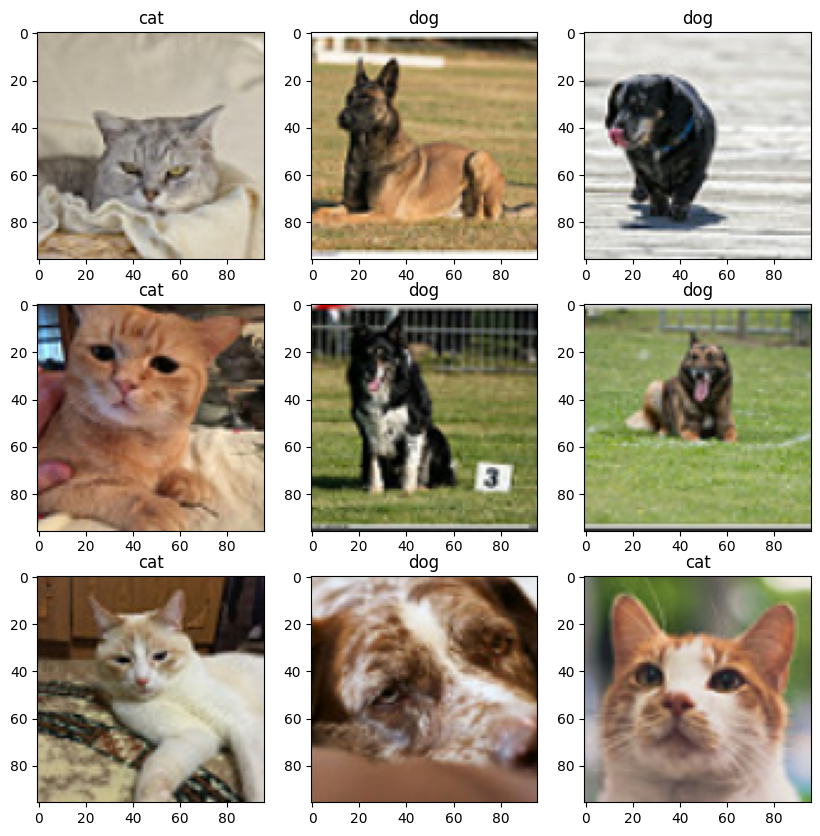

In [24]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])


In [25]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

# 水増しの実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

In [27]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(96, 96, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(96, 96, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [30]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7614 - loss: 0.4821
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9382 - loss: 0.1684
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9519 - loss: 0.1557
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9719 - loss: 0.0987
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9826 - loss: 0.0829
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9832 - loss: 0.0685
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9909 - loss: 0.0641
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9946 - loss: 0.0540
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9939 - loss: 0.0458
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9974 - loss: 0.0373
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9977 - loss: 0.0349
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy:

In [31]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)
pred_data

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


array([[8.52591638e-03],
       [2.77037645e-04],
       [1.07222826e-04],
       [1.11793845e-04],
       [2.05308036e-03],
       [3.72452452e-03],
       [2.76852545e-04],
       [7.84424366e-04],
       [1.72872317e-03],
       [1.03651884e-03],
       [3.57981742e-04],
       [2.97855027e-02],
       [1.00205652e-03],
       [1.50232315e-01],
       [3.11199459e-04],
       [1.00066350e-03],
       [2.39596039e-01],
       [3.46066291e-03],
       [1.25749060e-03],
       [1.97473797e-04],
       [2.03391843e-04],
       [9.64479614e-03],
       [2.84740207e-04],
       [8.16539687e-04],
       [7.44117677e-01],
       [8.29962446e-05],
       [3.72117129e-03],
       [2.24323114e-04],
       [1.48821086e-01],
       [4.89538768e-03],
       [8.54937476e-04],
       [7.24462450e-01],
       [1.41692126e-05],
       [4.73380700e-04],
       [2.79117818e-03],
       [7.23903120e-01],
       [9.49209109e-02],
       [1.31189099e-05],
       [4.83568961e-04],
       [2.18541682e-04],


In [32]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9599 - loss: 0.0679


[0.0516742579638958, 0.9700000286102295]